# 📘 Отчет о выполнении проекта по распознаванию автомобильных номеров

---

## 1. 🎯 Цель работы

Целью данной работы является реализация пайплайна для:

* Загрузки изображений автомобилей
* Обнаружения и распознавания автомобильных номеров
* Оценки качества распознавания

Дополнительно — устойчивость к искажениям, обработка видео и корректное форматирование результата.

In [52]:
import re
import os
import cv2
import easyocr
import random
import numpy as np
from matplotlib import pyplot as plt
from ppocr_det import PPOCRDet
from skimage import exposure, morphology, util, restoration
import evaluate
import albumentations as A
from ipywidgets import interact, IntSlider, FloatSlider, fixed
from fast_plate_ocr import ONNXPlateRecognizer
from transformers import AutoProcessor, AutoModelForImageTextToText
from PIL import Image

## 2. 🖼️ Загрузка изображений (или 🎞️ видео)

### 📂 Загрузка изображений:

Код выполняет две основные задачи:

1. **load_images(folder_name)** — загружает все `.jpg` и `.jpeg` изображения из указанной папки:
   - Преобразует изображения в формат RGB
   - Выводит сообщение о каждом успешно загруженном или пропущенном файле

2. **display_images(images, titles)** — отображает загруженные изображения в виде сетки:
   - Подписывает каждое изображение
   - Удаляет оси и корректно размещает элементы на графике

Загрузка всех изображений из папки `dataset` и их визуализация


Загружено: car1.jpg
Загружено: car2.jpg
Загружено: car3.jpg


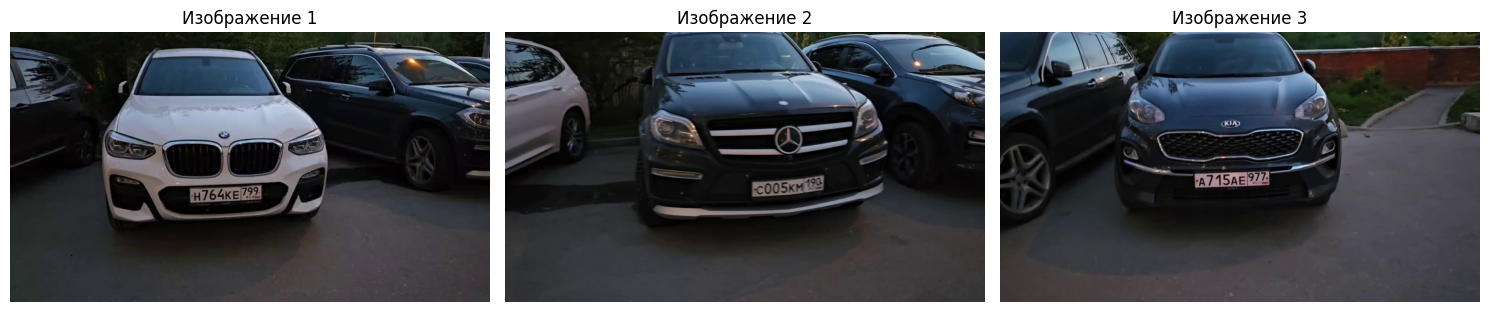

In [53]:
def load_images(folder_name):

    script_dir = os.path.dirname(os.path.abspath('__file__'))
    folder_path = os.path.join(script_dir, folder_name)

    images = []
    valid_extensions = ('.jpg', '.jpeg')

    if not os.path.exists(folder_path):
        print(f"Папка не найдена: {folder_path}")
        return images

    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(valid_extensions):
            filepath = os.path.join(folder_path, filename)
            img = cv2.imread(filepath)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                print(f"Загружено: {filename}")
            else:
                print(f"Не удалось прочитать: {filename}")

    return images

def display_images(images, titles, figsize=(15, 10)):
    n = len(images)
    if n == 0:
        print("Нет изображений для отображения")
        return

    cols = min(3, n)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes
    else:
        axes = axes.flatten()

    for i in range(n):
        if len(images[i].shape) == 3:
            axes[i].imshow(images[i])
        else:
            axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')
        if titles and i < len(titles):
            axes[i].set_title(titles[i])

    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

input_images = load_images("dataset")

display_images(input_images, [f"Изображение {i+1}" for i in range(len(input_images))])

### 🎞️ Извлечение кадров с автомобилями из видео (для доп. задания):

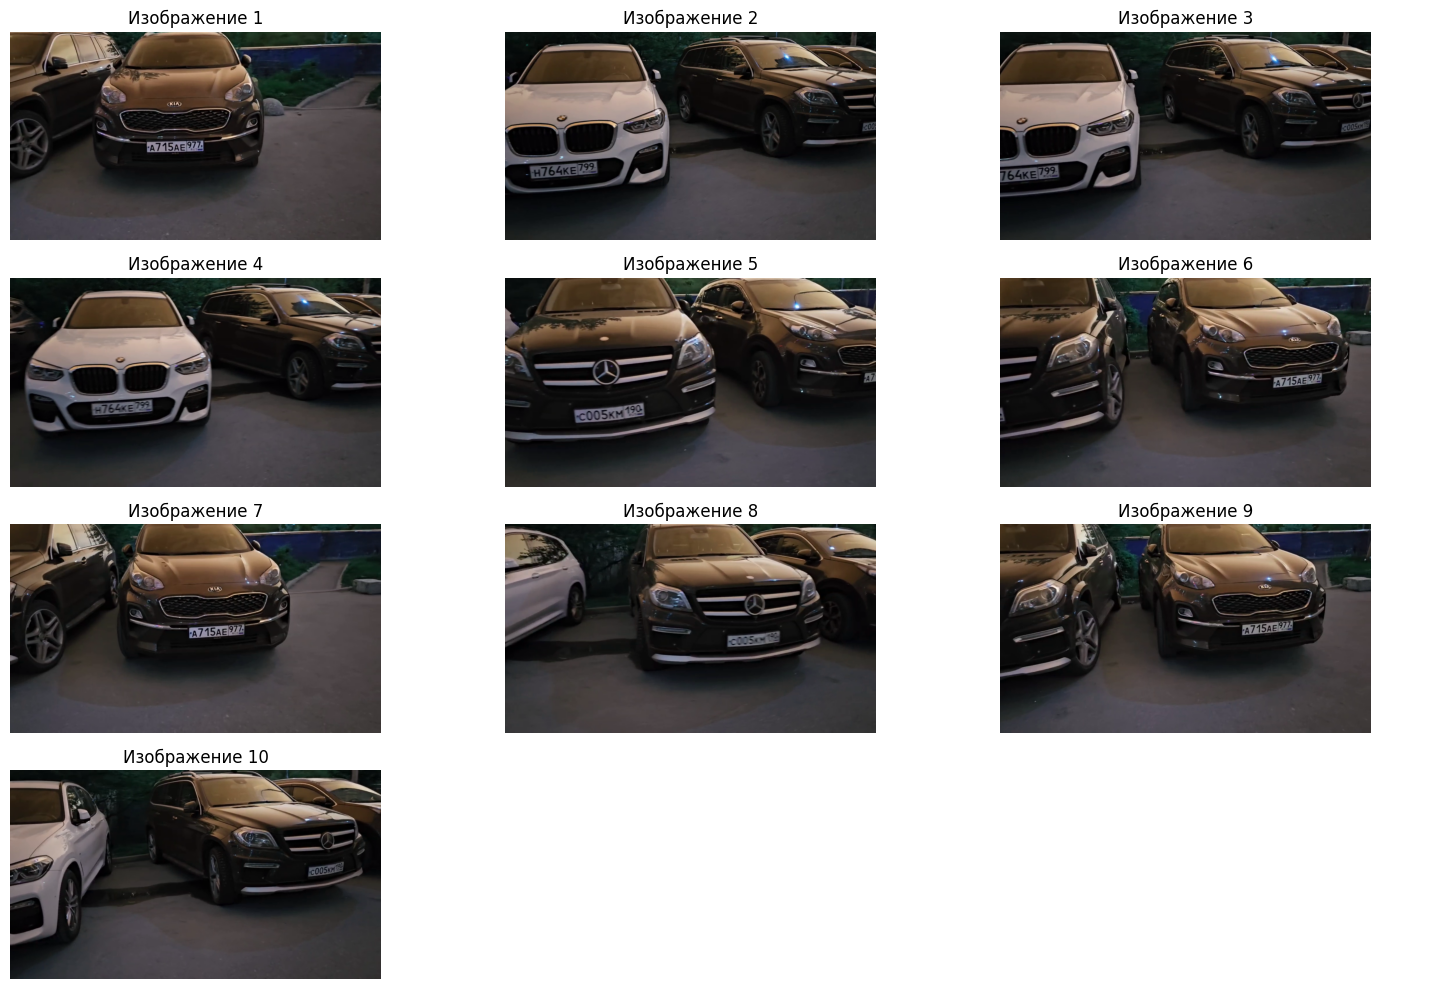

In [54]:
cap = cv2.VideoCapture("dataset/cam1.mp4")
frames_video = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    # Фильтрация по наличию автомобиля (пример — детектор)
    frames_video.append(frame)
cap.release()
frames_video_to_show = random.sample(frames_video, 10)
display_images(frames_video_to_show, [f"Изображение {i+1}" for i in range(len(frames_video_to_show))])

## 3. 🔁 Аугментация изображений

Для устойчивости алгоритма применим 2 случайные трансформации к каждому изображению (например, поворот и шум).

Применяемые преобразования со случайными параметрами:

- `add_gaussian_noise` — добавление случайного шума
- `adjust_brightness` — изменение яркости

Функция `augment_image` выбирает **случайные параметры для искаженний** и применяет их к каждому изображению

Затем отображаются:
- **Исходные изображения**
- **Аугментированные версии**

✓ Аугментировано изображение 1
✓ Аугментировано изображение 2
✓ Аугментировано изображение 3

Исходные изображения:


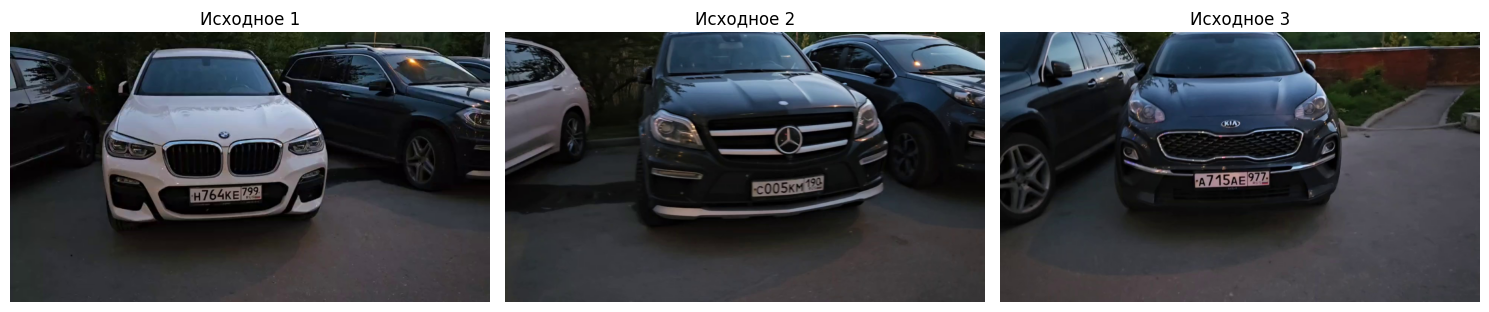

Аугментированные изображения:


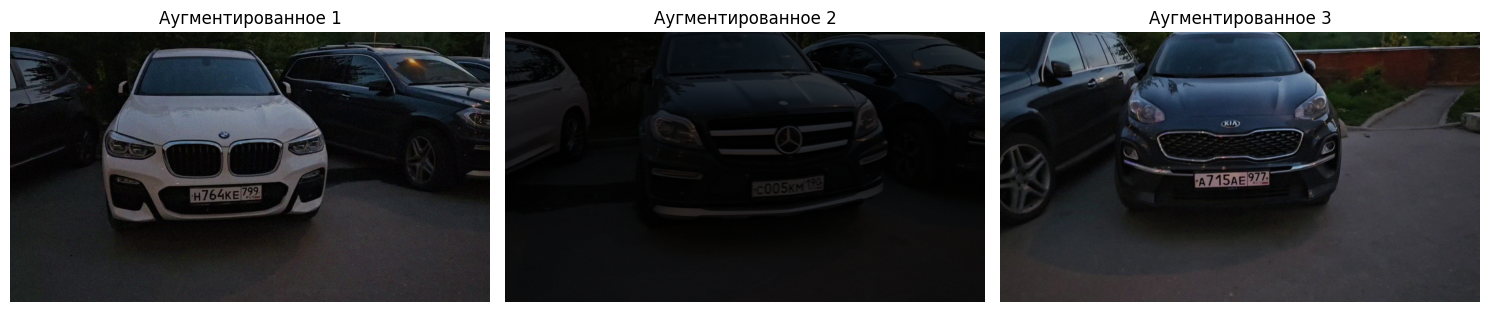

In [55]:
def add_gaussian_noise(img):
    noise_level = random.uniform(0.5, 1)
    std_dev = noise_level * 255
    noise = np.random.normal(0, std_dev, img.shape).astype(np.float32)
    img_float = img.astype(np.float32)
    noisy_img = img_float + 0.05 * noise
    noisy_img = np.clip(noisy_img, 0, 255)

    return noisy_img.astype(np.uint8)

def adjust_brightness(img):
    brightness_factor = random.uniform(0.2, 1)
    bet = random.randint(-1, 1)
    bright_img = cv2.convertScaleAbs(img, alpha=brightness_factor, beta=bet)
    return bright_img

def augment_image(img):
    transformations = [
        add_gaussian_noise,
        adjust_brightness
    ]

    selected_transforms = random.sample(transformations, 2)

    augmented_img = img.copy()
    for transform in selected_transforms:
        augmented_img = transform(augmented_img)

    return augmented_img

augmented_images = []
for i, img in enumerate(input_images):
    augmented = augment_image(img)
    augmented_images.append(augmented)
    print(f"✓ Аугментировано изображение {i+1}")

print("\nИсходные изображения:")
display_images(input_images, [f"Исходное {i+1}" for i in range(len(input_images))])

print("Аугментированные изображения:")
display_images(augmented_images, [f"Аугментированное {i+1}" for i in range(len(augmented_images))])

Также можно использовать библиотеку `albumentations`


Исходные изображения:


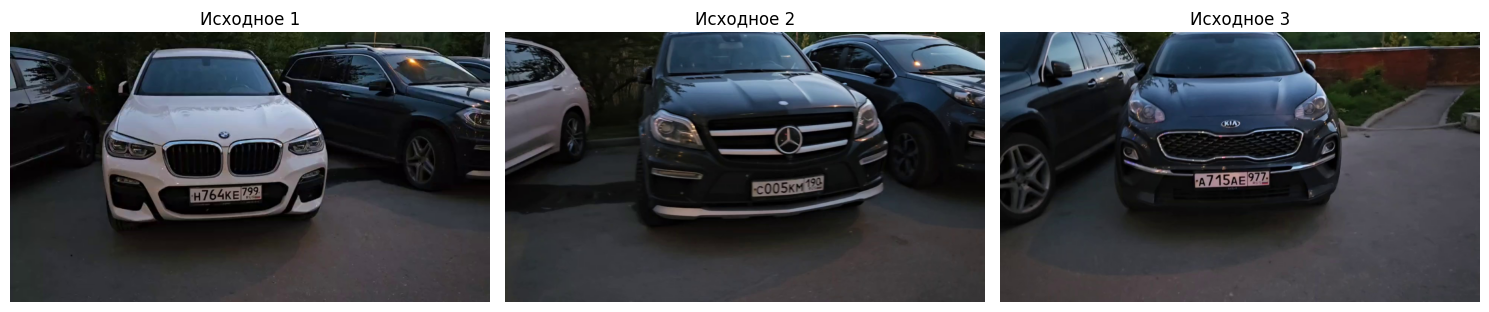

Аугментированные изображения (albumentations):


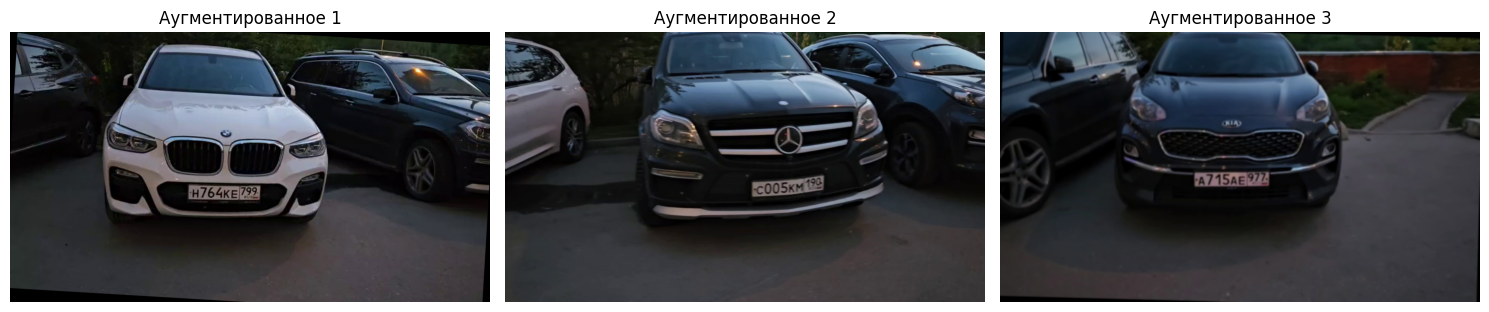

In [56]:


augment = A.Compose([
    A.Rotate(limit=10, p=0.5),
    A.GaussianBlur(p=0.5),
    A.RandomBrightnessContrast(p=0.5)
])

aug_images = [augment(image=img)["image"] for img in input_images]

# Визуализация
print("\nИсходные изображения:")
display_images(input_images, [f"Исходное {i+1}" for i in range(len(input_images))])

print("Аугментированные изображения (albumentations):")
display_images(aug_images, [f"Аугментированное {i+1}" for i in range(len(aug_images))])

## 4. 🧹 Предобработка изображений## Предобработка изображений

Код подготавливает изображения к распознаванию

Этапы предобработки:
1. **Преобразование в LAB** и выделение канала яркости (L)
2. **Шумоподавление** с помощью `fastNlMeansDenoising`
3. **Усиление контраста** через `CLAHE` (адаптивное гистограммное выравнивание)
4. **Бинаризация** изображения с помощью `adaptiveThreshold`
5. **Морфологическая операция** замыкания (`MORPH_CLOSE`) для устранения пробелов

Затем отображаются:
- **Аугментированные изображения**
- **Предобработанные версии**


До обработки:


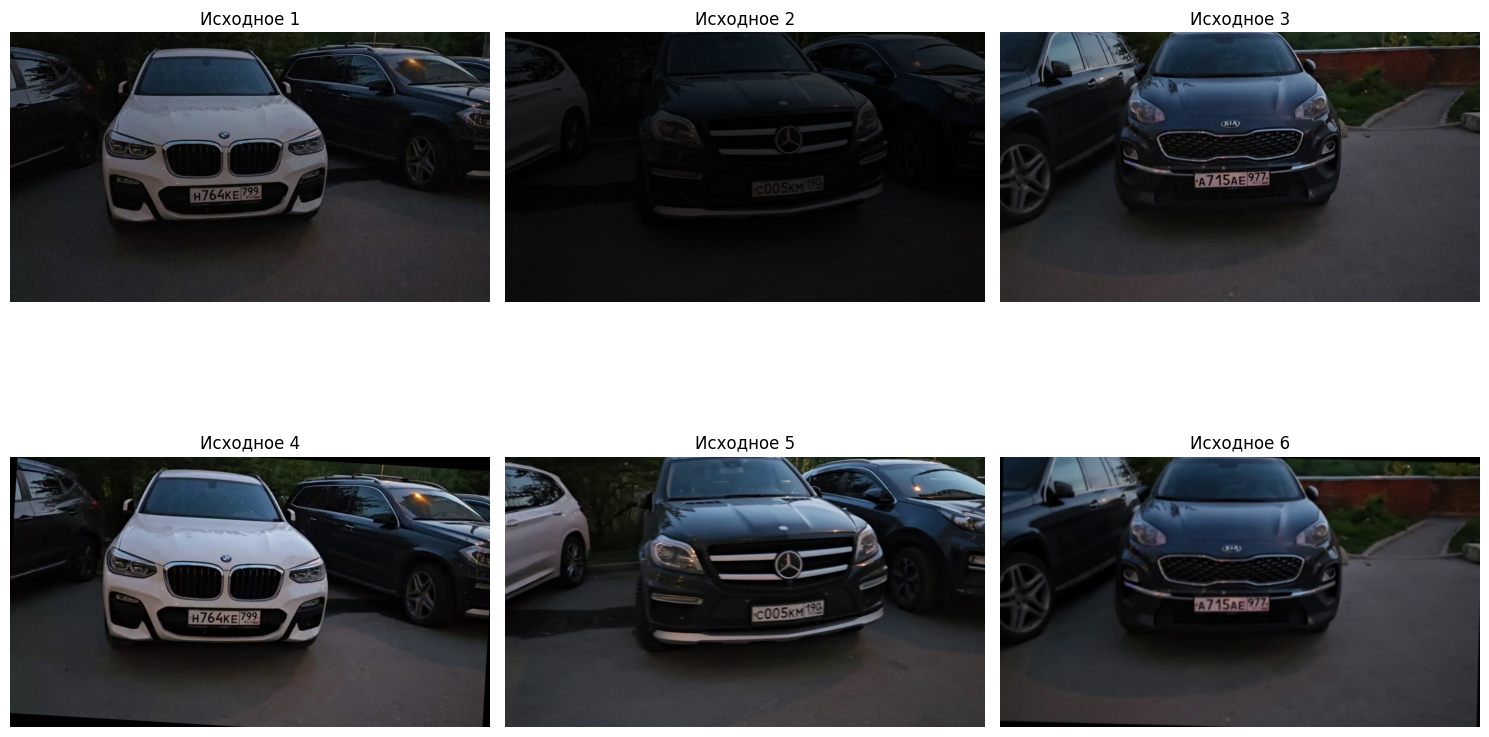

После обработки:


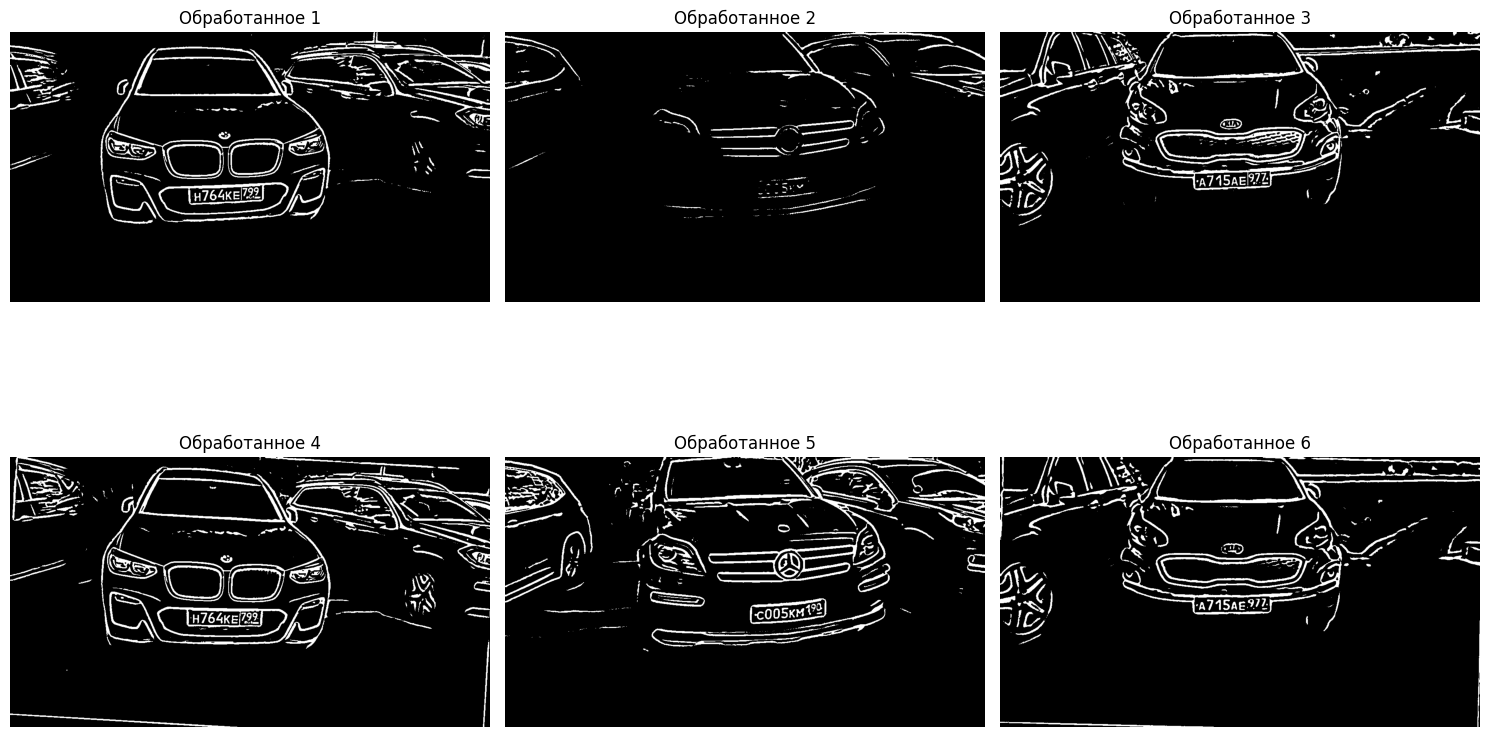

In [57]:
def preprocess_image(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)[:,:,0]

    denoised = cv2.fastNlMeansDenoising(
        gray,
        h=15,
        templateWindowSize=7,
        searchWindowSize=21
    )

    clahe = cv2.createCLAHE(
        clipLimit=3.0,
        tileGridSize=(12, 12)
    )
    enhanced = clahe.apply(denoised)

    binary = cv2.adaptiveThreshold(
        enhanced,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        21,
        9
    )

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return processed

preprocessed_images = []

extended_aug_images = augmented_images + aug_images
for i, img in enumerate(extended_aug_images):


    processed = preprocess_image(img)
    inv = 255 - processed
    preprocessed_images.append(processed)

print("\nДо обработки:")
display_images(extended_aug_images, [f"Исходное {i+1}" for i in range(len(extended_aug_images))])

print("После обработки:")
display_images(preprocessed_images, [f"Обработанное {i+1}" for i in range(len(preprocessed_images))])


## 5. 🧭 Поиск области с текстом (номер)



### Классический метод
Этот блок кода реализует функцию для поиска и выделения номерных знаков на входных изображениях.

#### Основные шаги:

1. **Фильтрация контуров по площади**  
   Отбрасываем мелкие контуры (площадь меньше 3000 пикселей).

2. **Фильтрация по аспектному отношению и размерам**  
   Выбираются области с соотношением ширины к высоте в диапазоне от 2 до 5 и с заданными ограничениями по ширине и высоте.

3. **Фильтрация по плотности белых пикселей**  
   Регион должен иметь плотность белых пикселей в диапазоне 0.05 - 0.8, чтобы соответствовать типичной текстуре номерного знака.

4. **Подсчет оценки кандидата на номер**  
   Оценка основывается на площади и близости аспектного отношения к идеальному (4.6).

5. **Дополнительная проверка через детекцию линий (Хаф)**  
   Для уточнения границ номерного знака используется детектор линий.

6. **Выбор лучшего кандидата**  
   Из лучших кандидатов выбирается тот, который расположен ближе всего к центру изображения.

7. **Извлечение области номерного знака с небольшим отступом**

---

#### Использование

- `get_plate(augmented_images, preprocessed_images)` — принимает аугментированные и предварительно обработанные изображения и возвращает список вырезанных изображений с номерами (или `None`, если номер не найден).

- `display_results(original_images, extracted_plates)` — визуализирует исходные изображения и соответствующие найденные номера в виде сетки.

---

##### Результат

Для каждого изображения из набора выводится:

- Исходное изображение
- Извлеченный номер (если найден)
- Сообщение о ненахождении номера (если номер не обнаружен)



=== Обработка изображения 1 ===
Номер найден! Размер: 200x57

=== Обработка изображения 2 ===
Номер не найден

=== Обработка изображения 3 ===
Номер найден! Размер: 209x53

=== Обработка изображения 4 ===
Номер найден! Размер: 147x48

=== Обработка изображения 5 ===
Номер найден! Размер: 203x65

=== Обработка изображения 6 ===
Номер не найден


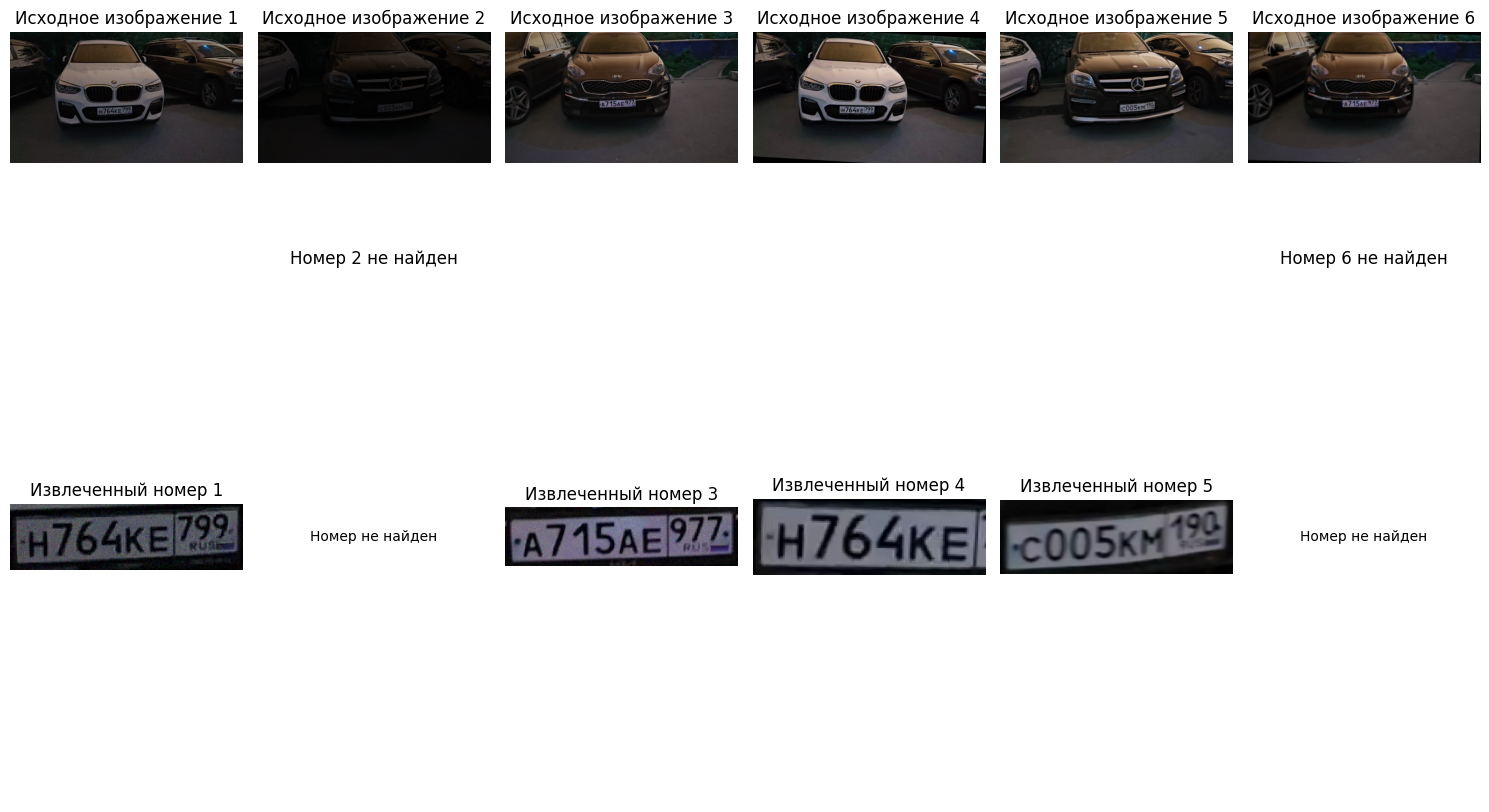

In [58]:
def get_plate(augmented_images, preprocessed_images):

    def filter_by_area(contour, min_area=3000):
        area = cv2.contourArea(contour)
        return area if area > min_area else None

    def filter_by_aspect_ratio(x, y, w, h, min_ratio=2.0, max_ratio=5.0, min_w=70, max_w=300, min_h=20, max_h=100):
        aspect_ratio = w / h
        if (min_ratio < aspect_ratio < max_ratio) and (min_w < w < max_w) and (min_h < h < max_h):
            return aspect_ratio
        return None

    def filter_by_density(roi, min_density=0.05, max_density=0.8):
        white_pixels = np.sum(roi == 255)
        total_pixels = roi.shape[0] * roi.shape[1]
        density = white_pixels / total_pixels
        return density if min_density < density < max_density else None

    def calculate_score(area, aspect_ratio, ideal_ratio=4.6):
        ratio_diff = abs(aspect_ratio - ideal_ratio)
        return area * max(0, (1 - ratio_diff / ideal_ratio))

    def distance_from_center(candidate, image_center_x):
        x, y, w, h, score, _ = candidate
        center_x = x + w / 2
        return abs(center_x - image_center_x)

    def find_plate_contour_precise(preprocessed_img, original_img, top_n=3):
        plate_candidates = []
        gray = preprocessed_img.copy()
        contours, _ = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            area = filter_by_area(contour)
            if not area:
                continue

            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = filter_by_aspect_ratio(x, y, w, h)
            if not aspect_ratio:
                continue

            roi = gray[y:y+h, x:x+w]
            density = filter_by_density(roi)
            if not density:
                continue

            score = calculate_score(area, aspect_ratio)
            if score > 0:
                roi_color = original_img[y:y+h, x:x+w]
                edges = cv2.Canny(roi_color, 50, 150)
                lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=30, minLineLength=20, maxLineGap=10)
                if lines is not None:
                    xs, ys, xe, ye = [], [], [], []
                    for line in lines:
                        for x1, y1, x2, y2 in line:
                            xs.extend([x1, x2])
                            ys.extend([y1, y2])
                    min_x, max_x = min(xs), max(xs)
                    min_y, max_y = min(ys), max(ys)
                    rect = (x + min_x, y + min_y, max_x - min_x, max_y - min_y)
                else:
                    rect = (x, y, w, h)

                plate_candidates.append((x, y, w, h, score, rect))

        if not plate_candidates:
            return None

        plate_candidates = sorted(plate_candidates, key=lambda x: x[4], reverse=True)[:top_n]
        image_center_x = gray.shape[1] / 2
        best_candidate = min(plate_candidates, key=lambda c: distance_from_center(c, image_center_x))
        return best_candidate[5]

    def extract_plate_region(original_img, preprocessed_img):
        rect = find_plate_contour_precise(preprocessed_img, original_img)
        if rect is None:
            return None

        x, y, w, h = rect
        if not (w > 30 and h > 10 and w < original_img.shape[1] * 0.8 and h < original_img.shape[0] * 0.3):
            return None

        padding = 5
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = min(original_img.shape[1] - x, w + 2 * padding)
        h = min(original_img.shape[0] - y, h + 2 * padding)

        if w > 0 and h > 0:
            return original_img[y:y+h, x:x+w]

        return None

    extracted_plates = []

    for i in range(len(augmented_images)):
        print(f"\n=== Обработка изображения {i+1} ===")
        original = augmented_images[i]
        preprocessed = preprocessed_images[i]
        plate = extract_plate_region(original, preprocessed)
        if plate is not None and plate.size > 0:
            extracted_plates.append(plate)
            print(f"Номер найден! Размер: {plate.shape[1]}x{plate.shape[0]}")
        else:
            print("Номер не найден")
            extracted_plates.append(None)

    return extracted_plates

def display_results(original_images, extracted_plates):
    fig, axes = plt.subplots(2, len(original_images), figsize=(15, 10))
    for i in range(len(original_images)):
        if len(original_images[i].shape) == 3:
            axes[0, i].imshow(cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB))
        else:
            axes[0, i].imshow(original_images[i], cmap='gray')
        axes[0, i].set_title(f'Исходное изображение {i+1}')
        axes[0, i].axis('off')
        if extracted_plates[i] is not None:
            if len(extracted_plates[i].shape) == 3:
                axes[1, i].imshow(cv2.cvtColor(extracted_plates[i], cv2.COLOR_BGR2RGB))
            else:
                axes[1, i].imshow(extracted_plates[i], cmap='gray')
            axes[1, i].set_title(f'Извлеченный номер {i+1}')
        else:
            axes[1, i].text(0.5, 0.5, 'Номер не найден', ha='center', va='center', transform=axes[1, i].transAxes)
            axes[1, i].set_title(f'Номер {i+1} не найден')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

found_plates = get_plate(extended_aug_images, preprocessed_images)
display_results(extended_aug_images, found_plates)

### Поиск области номерного знака с помощью PPOCR

Этот блок кода реализует функцию, которая находит область с номерным знаком на изображении, используя модель обнаружения текста PPOCR.

#### Распознавание текста на изображениях

Код ниже подготавливает три компонента:

- **EasyOCR** — распознаёт текст (русский язык, используется GPU)
- **PPOCR (PaddleOCR)** — используется как дополнительный вариант нахождения номерного знака на изображении

Используется:
- ONNX-модель детектора текста (`text_detection_cn_ppocrv3_2023may.onnx`)

---

#### Алгоритм работы:

1. **Предварительная обработка**  
   Исходное изображение масштабируется до фиксированного размера 736×736 для подачи на вход детектору.

2. **Инференс модели PPOCR**  
   Модель `detector` (PPOCR) возвращает список координат областей с текстом на уменьшенном изображении.

3. **Масштабирование координат обратно к исходному размеру**  
   Координаты найденных боксов масштабируются с учётом соотношения размеров исходного и входного изображения.

4. **Фильтрация кандидатов по геометрическим параметрам**  
   Оценивается каждый бокс по:
   - Соотношению сторон (2 до 5)
   - Минимальной площади (больше 0.3% площади изображения)
   - Минимальной ширине (50 пикселей) и высоте (15 пикселей)

5. **Выбор лучшего кандидата**  
   Из подходящих боксов выбирается самый большой по площади.

6. **Добавление небольших отступов**  
   К выбранному боксу добавляется паддинг для захвата всей области номерного знака.

7. **Возврат обрезанного региона номерного знака**  
   Возвращается вырезанная область исходного изображения.

---

#### Использование:

- `get_plate_ppocr(detector, original_img)` — функция для извлечения номерного знака из одного изображения.

- Цикл проходит по списку изображений и выводит информацию о найденных областях.

- Если номер не найден, вместо него добавляется серый прямоугольник-заглушка.

- Функция `display_images` отображает номера.

---

#### Результаты

Для каждого изображения выводится сообщение о том, найден ли номер, и отображаются выделенные области.


In [59]:
reader = easyocr.Reader(['ru'], gpu=True)

ppocr_model = PPOCRDet(
    modelPath='./text_detection_cn_ppocrv3_2023may.onnx',
    inputSize=[736, 736],
    binaryThreshold=0.3,
    polygonThreshold=0.5,
    maxCandidates=200,
    unclipRatio=2.0,
    backendId=cv2.dnn.DNN_BACKEND_OPENCV,
    targetId=cv2.dnn.DNN_TARGET_CPU)


ПОИСК ОБЛАСТИ С ТЕКСТОМ С ПОМОЩЬЮ PPOCR
Найдена область номера на изображении 1
Найдена область номера на изображении 2
Найдена область номера на изображении 3
Найдена область номера на изображении 4
Найдена область номера на изображении 5
Найдена область номера на изображении 6

Найдено областей с номерами: 6


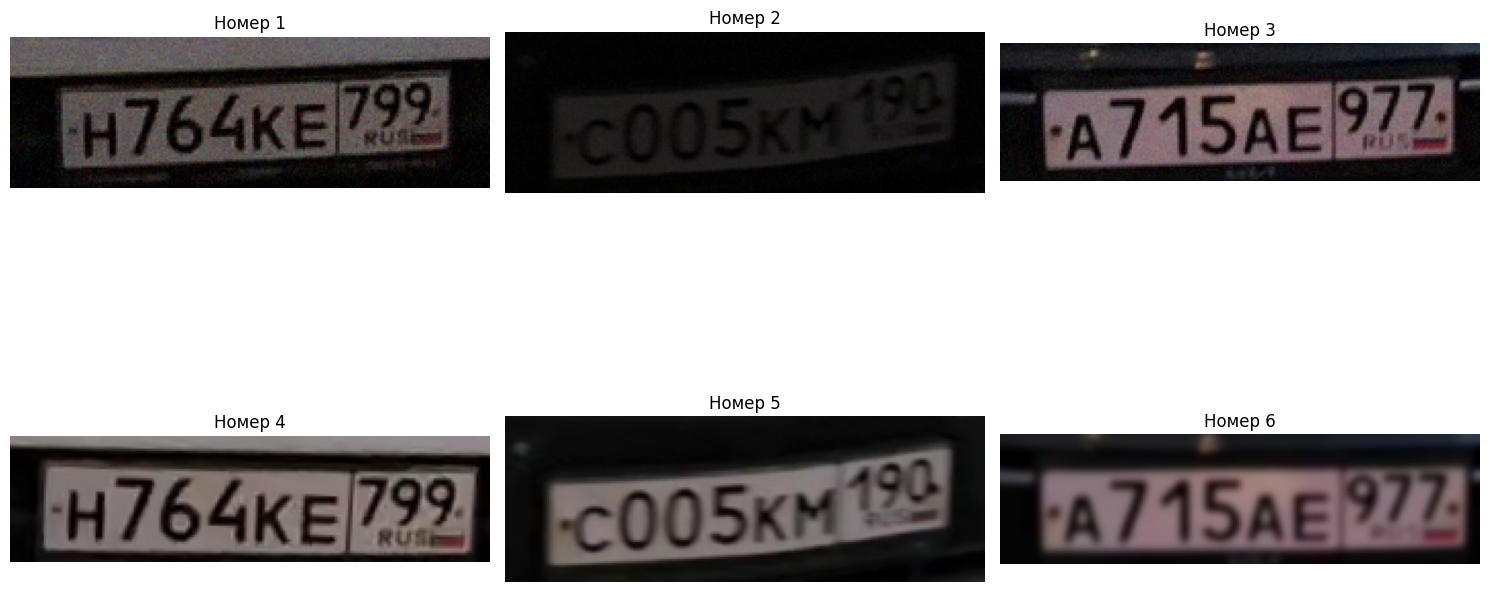

In [60]:
def get_plate_ppocr(detector, original_img):

    height, width = 736, 736
    input_img = cv2.resize(original_img, (width, height))
    scale_h = original_img.shape[0] / height
    scale_w = original_img.shape[1] / width

    results = detector.infer(input_img)

    scaled_boxes = []
    for box in results[0]:
        scaled_box = np.array([[int(pt[0] * scale_w), int(pt[1] * scale_h)] for pt in box])
        scaled_boxes.append(scaled_box)

    plate_candidates = []
    for box in scaled_boxes:
        x, y, w, h = cv2.boundingRect(box)
        aspect_ratio = w / h
        area = w * h
        img_area = original_img.shape[0] * original_img.shape[1]

        if (2 <= aspect_ratio <= 5 and
            area > img_area * 0.003 and
            w > 50 and h > 15):
            plate_candidates.append((x, y, w, h))

    if not plate_candidates:
        return None

    x, y, w, h = max(plate_candidates, key=lambda item: item[2] * item[3])
    margin_x = max(10, int(w * 0.05))
    margin_y = max(10, int(h * 0.1))

    x = max(0, x - margin_x)
    y = max(0, y - margin_y)
    w = min(original_img.shape[1] - x, w + margin_x)
    h = min(original_img.shape[0] - y, h + margin_y)

    plate = original_img[y:y + h, x:x + w]
    return plate

print("\n" + "="*60)
print("ПОИСК ОБЛАСТИ С ТЕКСТОМ С ПОМОЩЬЮ PPOCR")
print("="*60)

found_plates = []
for i, (orig_img, preproc_img) in enumerate(zip(extended_aug_images, preprocessed_images)):
    plate = get_plate_ppocr(ppocr_model, orig_img)
    if plate is not None:
        found_plates.append(plate)
        print(f"Найдена область номера на изображении {i+1}")
    else:
        print(f"Область номера не найдена на изображении {i+1}")
        found_plates.append(np.ones((50, 100, 3), dtype=np.uint8) * 128)

print(f"\nНайдено областей с номерами: {len([p for p in found_plates if p.shape[0] > 50])}")
display_images(found_plates, [f"Номер {i+1}" for i in range(len(found_plates))])

## 6. 🧼 Предобработка номера

Данный блок выполняет очистку найденных областей с номерами:

- Масштабирование изображения (увеличение в 2 раза)
- Преобразование в градации серого
- Шумоподавление с помощью билатерального и TV-фильтра
- Повышение локального контраста (CLAHE)
- Гауссово размытие и бинаризация методом Отсу
- Морфологическое открытие для удаления мелких шумов

В конце выводится сравнение исходного изображения и результата очистки для каждой области.

---


5. ПРЕДОБРАБОТКА ОБЛАСТИ С ТЕКСТОМ
✓ Обработан номер 1


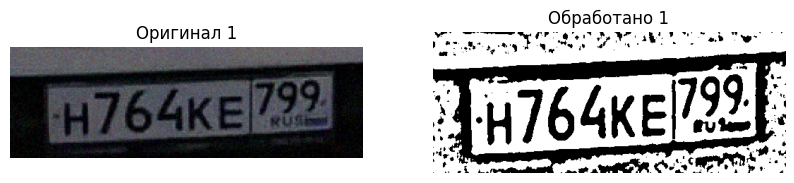

✓ Обработан номер 2


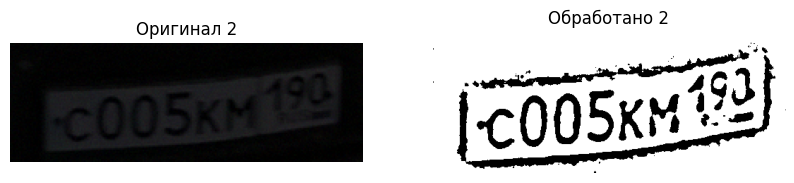

✓ Обработан номер 3


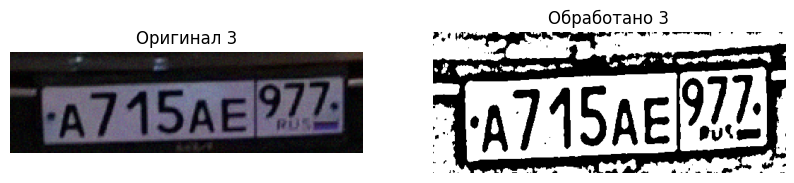

✓ Обработан номер 4


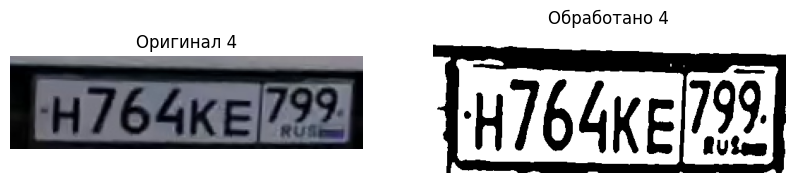

✓ Обработан номер 5


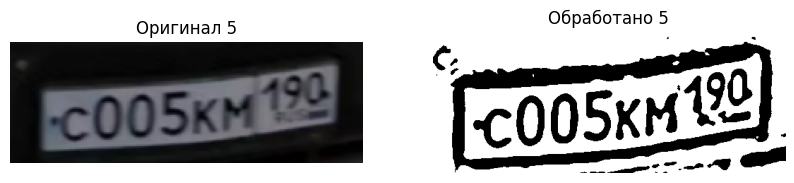

✓ Обработан номер 6


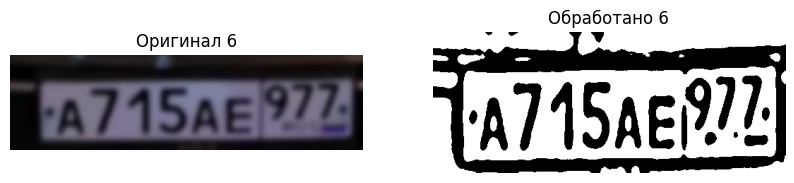

In [61]:

# @interact(
#     plates=fixed(found_plates),
#     des_width=IntSlider(min=100, max=800, step=1, value=500, description='Desired width:'),
#     des_height=IntSlider(min=100, max=800, step=1, value=200, description='Desired height:'),
#     sharpening_kernel=IntSlider(min=0, max=20, step=1, value=6, description='Sharpening kernel:'),
#     alpha=FloatSlider(min=0, max=10, step=0.1, value=1, description='Alpha:'),
#     beta=FloatSlider(min=0, max=10, step=0.1, value=0, description='Beta:'),
#     gamma=FloatSlider(min=0, max=10, step=0.1, value=0, description='Gamma:'),
#     block_size=IntSlider(min=1, max=255, step=2, value=47, description='Binary threshold 1:'),
#     C_constant=IntSlider(min=0, max=255, step=1, value=10, description='Binary threshold 2:'),
#     median_kernel=IntSlider(min=1, max=27, step=2, value=7, description='Median kernel:')
# )
def get_clean_plates(plates, des_width = 500, des_height = 200, sharpening_kernel = 6, alpha = 1, beta = 0, gamma = 0, block_size = 47, C_constant = 5, median_kernel = 7):
    clean_plates = []
    for plate in plates:
        plate = plate.copy()
        # Resize if needed
        plate = cv2.resize(plate, (des_width, des_height), interpolation=cv2.INTER_CUBIC)


        # Convert to grayscale
        gray = cv2.cvtColor(plate, cv2.COLOR_RGB2GRAY) if len(plate.shape) == 3 else plate.copy()
        gray = util.img_as_float(gray)


        gray = (gray * 255).astype(np.uint8)
        # Sharpening
        kernel = np.array([
            [0, -1, 0],
            [-1, sharpening_kernel, -1],
            [0, -1, 0]
        ])

        sharpened_image = cv2.filter2D(gray, -1, kernel)

        # Add more contrast
        contrast_image = cv2.addWeighted(sharpened_image, alpha, sharpened_image, beta, gamma)


        # Apply adaptive thresholding with Gaussian window for robust binarization
        adaptive_binary = cv2.adaptiveThreshold(contrast_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C_constant)
        # Apply median blur
        median_blurred_image = cv2.medianBlur(adaptive_binary, median_kernel)

    #     # show binary and gray
    #     fig, axs = plt.subplots(1, 5, figsize=(10, 4))

    #     axs[0].imshow(plate, cmap='gray')
    #     axs[0].set_title('Plate')
    #     axs[0].axis('off')
    #     axs[1].imshow(sharpened_image, cmap='gray')
    #     axs[1].set_title('sharpened_image')
    #     axs[1].axis('off')
    #     axs[2].imshow(contrast_image, cmap='gray')
    #     axs[2].set_title('Contrast image')
    #     axs[2].axis('off')
    #     axs[3].imshow(adaptive_binary, cmap='gray')
    #     axs[3].set_title('Adaptive binary')
    #     axs[3].axis('off')
    #     axs[4].imshow(median_blurred_image, cmap='gray')
    #     axs[4].set_title('Median blurred image')
    #     axs[4].axis('off')
        clean_plates.append(median_blurred_image)
    # plt.show()
    return clean_plates

print("\n" + "="*60)
print("5. ПРЕДОБРАБОТКА ОБЛАСТИ С ТЕКСТОМ")
print("="*60)

clean_plates = get_clean_plates(found_plates)
clean_gray_plates = []
for i, plate in enumerate(clean_plates):
    if plate.shape[0] > 50:
        print(f"✓ Обработан номер {i+1}")

    # Построение сравнения до / после
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(cv2.cvtColor(found_plates[i], cv2.COLOR_BGR2RGB) if len(found_plates[i].shape) == 3 else found_plates[i], cmap='gray')
    axs[0].set_title(f"Оригинал {i+1}")
    axs[0].axis('off')

    axs[1].imshow(plate, cmap='gray')
    axs[1].set_title(f"Обработано {i+1}")
    axs[1].axis('off')
    plt.show()


## 7. 🔠 Распознавание текста

В этом блоке кода реализована функция для распознавания текста с обрезанных изображений номерных знаков с помощью EASYOCR `reader`.

---

### Описание функции `get_raw_text(clean_plate)`:

1. **Проверка пустоты изображения**  
   Если высота изображения меньше или равна 50 пикселям, считаем, что изображение пустое — возвращаем пустую строку.

2. **Первый проход OCR с фильтром символов**  
   - Используется параметр `allowlist`, который ограничивает распознаваемые символы допустимыми буквами (латиница и кириллица) и цифрами.
   - Параметры `width_ths` и `height_ths` задают пороги для фильтрации текста по ширине и высоте.
   - Если есть результаты, выбирается тот, у которого максимальная уверенность (`confidence`).
   - Если уверенность больше 0.3, возвращается распознанный текст в верхнем регистре без пробелов.

3. **Второй проход OCR без ограничений**  
   - Если первый проход не дал результата, повторяется попытка без `allowlist` и с другими порогами.
   - Выбирается результат с максимальным произведением длины текста на уверенность.

4. **Обработка ошибок**  
   При возникновении исключений выводится сообщение об ошибке, функция возвращает пустую строку.

---

### Использование:

- Проход по списку вырезанных изображений `clean_plates`.
- Для каждого изображения вызывается `get_raw_text`.
- Результаты сохраняются в список `raw_texts`.
- В консоль выводится распознанный текст или сообщение о его отсутствии.

---

### Итог

Функция возвращает строку с распознанным номером (заглавными буквами, без пробелов) либо пустую строку, если распознавание не удалось.


In [62]:
def get_raw_text(clean_plate):
    try:
        results = reader.readtext(
            clean_plate,
            allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZАВЕКМНОРСТУХ0123456789',
            paragraph=False,
            width_ths=0.7,
            height_ths=0.7
        )

        if results:
            best_result = max(results, key=lambda x: x[2])
            text = best_result[1]
            confidence = best_result[2]


            if confidence > 0.3:
                return text.upper().replace(' ', '')

        results_alt = reader.readtext(
            clean_plate,
            paragraph=False,
            width_ths=0.5,
            height_ths=0.5
        )

        if results_alt:
            best_alt = max(results_alt, key=lambda x: len(x[1]) * x[2])
            return best_alt[1].upper().replace(' ', '')

    except Exception as e:
        print(f"Ошибка при распознавании: {e}")

    return ""

print("\n" + "="*60)
print("6. РАСПОЗНАВАНИЕ ТЕКСТА [EASYOCR]")
print("="*60)

raw_texts = []
for i, clean_plate in enumerate(clean_plates):
    raw_text = get_raw_text(clean_plate)
    raw_texts.append(raw_text)
    if raw_text:
        print(f"Распознан текст на номере {i+1}: '{raw_text}'")
    else:
        print(f"Текст не распознан на номере {i+1}")

print(f"\nРаспознанные тексты: {raw_texts}")


6. РАСПОЗНАВАНИЕ ТЕКСТА [EASYOCR]
Распознан текст на номере 1: 'H764Е99'
Распознан текст на номере 2: '(ОО5КМА'
Распознан текст на номере 3: '{47154/89Ъ'
Распознан текст на номере 4: 'Н64Е'
Распознан текст на номере 5: 'COOSKM199'
Распознан текст на номере 6: '47I5NE0'

Распознанные тексты: ['H764Е99', '(ОО5КМА', '{47154/89Ъ', 'Н64Е', 'COOSKM199', '47I5NE0']


## Используем fast_plate_ocr

*************** EP Error ***************
EP Error D:\a\_work\1\s\onnxruntime\python\onnxruntime_pybind_state.cc:505 onnxruntime::python::RegisterTensorRTPluginsAsCustomOps Please install TensorRT libraries as mentioned in the GPU requirements page, make sure they're in the PATH or LD_LIBRARY_PATH, and that your GPU is supported.
 when using ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.
****************************************

7. РАСПОЗНАВАНИЕ ТЕКСТА [FAST_PLATE_OCR]
Распознан текст на номере 1: '2754EA1__'


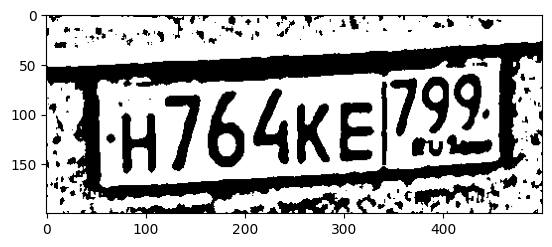

Распознан текст на номере 2: '1005_A19_'


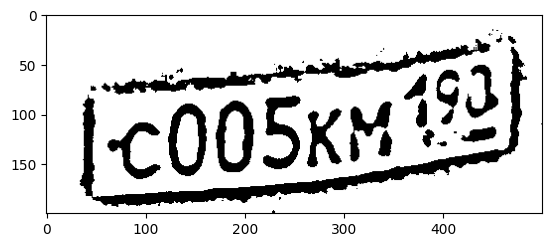

Распознан текст на номере 3: '4715A5777'


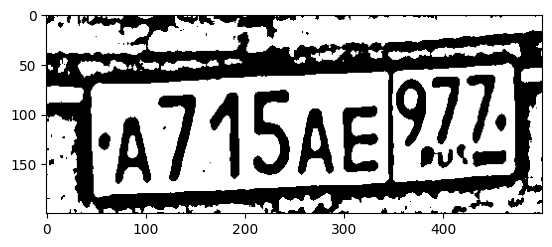

Распознан текст на номере 4: 'H764E279_'


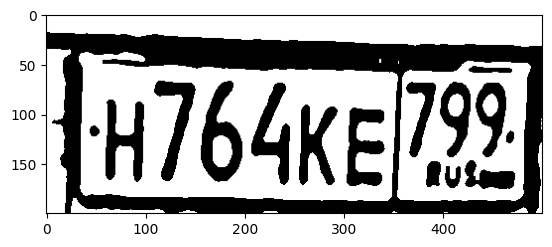

Распознан текст на номере 5: 'CO05_____'


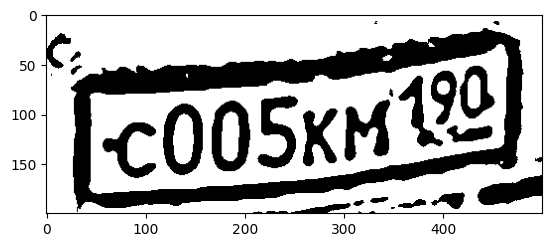

Распознан текст на номере 6: 'A715E977_'


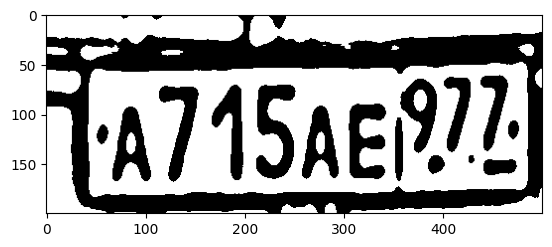


Распознанные тексты: ['2754EA1__', '1005_A19_', '4715A5777', 'H764E279_', 'CO05_____', 'A715E977_']


In [63]:

m = ONNXPlateRecognizer('global-plates-mobile-vit-v2-model')
def get_fast_plate_ocr_text(plate_img: np.ndarray):
    text = m.run(plate_img)[0]
    return text
def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

print("\n" + "="*60)
print("7. РАСПОЗНАВАНИЕ ТЕКСТА [FAST_PLATE_OCR]")
print("="*60)

fast_plate_ocr_texts = []
for i, found_plate in enumerate(clean_plates):
    fast_plate_ocr_text = get_fast_plate_ocr_text(found_plate)
    fast_plate_ocr_texts.append(fast_plate_ocr_text)
    if fast_plate_ocr_text:
        print(f"Распознан текст на номере {i+1}: '{fast_plate_ocr_text}'")
        display_image(found_plate)
    else:
        print(f"Текст не распознан на номере {i+1}")


print(f"\nРаспознанные тексты: {fast_plate_ocr_texts}")

### Use GOT-OCR-2.0-hf

H764KE799.
H764KE799.


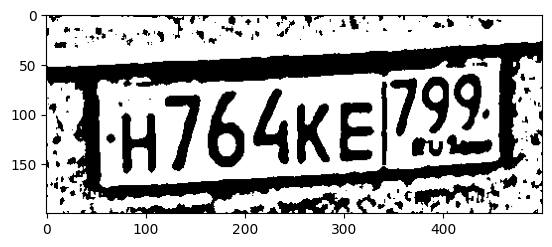

COOSKM
COOSKM


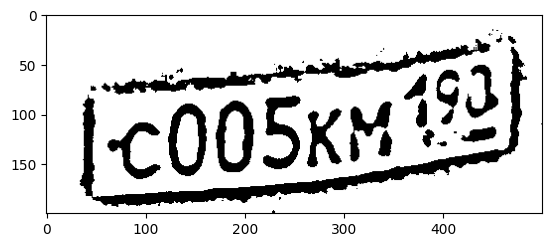

A715AE977
A715AE977


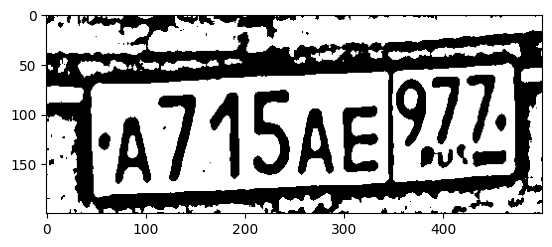

H764KE799
H764KE799


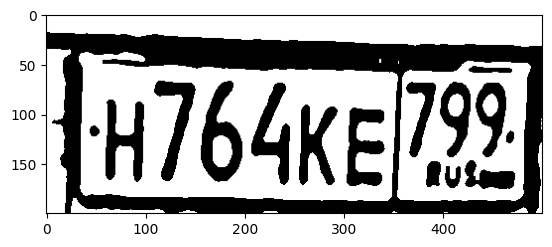

c005KM190
c005KM190


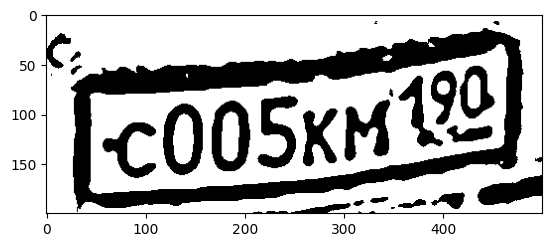

A715AE97Z
A715AE97Z


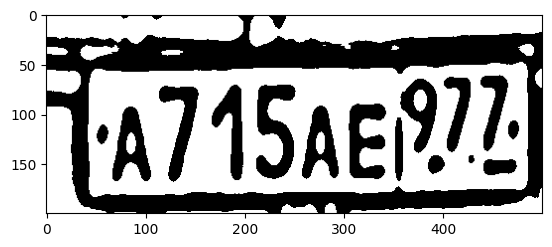

In [64]:

model = AutoModelForImageTextToText.from_pretrained("stepfun-ai/GOT-OCR-2.0-hf")
processor = AutoProcessor.from_pretrained("stepfun-ai/GOT-OCR-2.0-hf")

got_ocr_texts = []
for i, found_plate in enumerate(clean_plates):
    found_plate_pil = Image.fromarray(found_plate).convert('RGB')
    inputs = processor(found_plate_pil, return_tensors="pt")
    generated_ids = model.generate(
    **inputs,
    do_sample=True,
    tokenizer=processor.tokenizer,
    stop_strings="<|im_end|>",
    max_new_tokens=4096,
    )
    outputs = processor.batch_decode(generated_ids[:, inputs["input_ids"].shape[1] :], skip_special_tokens=True)
    for output in outputs:
        output = output.replace(" ", "")
        print(output)
    got_ocr_texts.append(output)

    print(got_ocr_texts[-1])
    display_image(found_plate)




In [65]:
! python License_Plate_Recognition/main.py --image dataset/car2.jpg

C:\Users\Dell\AppData\Local\Programs\Python\Python310\python.exe: can't open file 'c:\\Users\\Dell\\Downloads\\Telegram Desktop\\CV_final_project\\License_Plate_Recognition\\main.py': [Errno 2] No such file or directory


## 8. ✏️ Коррекция текста

Данный блок содержит функцию `get_number`, которая принимает сырой текст с номерного знака и приводит его к корректному и стандартизированному формату российского номера.

---

### Что делает функция `get_number(raw_text)`:

1. **Преобразование в верхний регистр**  
   Текст переводится в верхний регистр для унификации.

2. **Замена латинских букв на кириллические**  
   Многие буквы внешне похожи, поэтому латинские символы, часто ошибочно распознаваемые OCR, заменяются на соответствующие кириллические.

3. **Очистка от недопустимых символов**  
   Удаляются все символы, кроме цифр и разрешённых букв: `АВЕКМНОРСТУХ`.

4. **Проверка длины строки**  
   Номер должен содержать от 8 до 10 символов.

5. **Исправление букв и цифр**  
   - Если символ должен быть буквой, но является цифрой, происходит попытка замены на букву (и наоборот).  
   - Это позволяет исправлять ошибки OCR, например, `О` ↔ `0`, `С` ↔ `5` и т.п.

6. **Валидация регионального кода**  
   Регион — 2 или 3 цифры, проверяется диапазон допустимых номеров (1-1999) и несколько спецзначений.

7. **Формирование итогового номера**  
   Номер возвращается в формате `"X111XX 777"` — где X — буква, 1 — цифра, 777 — регион.

---

### Использование:

- Для каждого распознанного текста из списка `raw_texts` вызывается `get_number`.
- Результат либо корректный номер, либо пометка `НЕ ВАЛИДНЫЙ`.

---

### Итог

Функция позволяет повысить качество распознавания, исправляя типичные ошибки OCR и отбрасывая неверные варианты.


In [66]:
def get_number(raw_text: str) -> str:
    if not raw_text:
        return ""

    raw_text = raw_text.upper()

    valid_letters = "АВЕКМНОРСТУХ"

    latin_to_cyrillic = {
        'A': 'А', 'B': 'В', 'C': 'С', 'E': 'Е', 'H': 'Н',
        'K': 'К', 'M': 'М', 'O': 'О', 'P': 'Р', 'T': 'Т',
        'X': 'Х', 'Y': 'У', 'S': 'С', 'Z': '7', 'V': 'В', 'L': 'Л'
    }

    letter_to_digit = {
        'О': '0', 'З': '3', 'В': '8', 'Б': '6', 'Г': '9', 'Т': '7',
        'С': '5', 'Л': '1', 'Е': '3', 'Н': '4', 'А': '4', 'Р': '9'
    }

    digit_to_letter = {v: k for k, v in letter_to_digit.items()}

    fixed_text = "".join(latin_to_cyrillic.get(ch, ch) for ch in raw_text)

    fixed_text = re.sub(f"[^\d{valid_letters}]", "", fixed_text)

    if not (8 <= len(fixed_text) <= 10):
        return ""

    def fix_letter(ch):
        if ch in valid_letters:
            return ch
        return digit_to_letter.get(ch)

    def fix_digit(ch):
        if ch.isdigit():
            return ch
        return letter_to_digit.get(ch)

    if len(fixed_text) < 8:
        return ""

    letter1 = fix_letter(fixed_text[0])
    if not letter1:
        return ""

    digits_part = []
    for i in range(1, 4):
        if i >= len(fixed_text):
            return ""
        d = fix_digit(fixed_text[i])
        if not d:
            return ""
        digits_part.append(d)

    letters2 = []
    for i in range(4, 6):
        if i >= len(fixed_text):
            return ""
        l = fix_letter(fixed_text[i])
        if not l:
            return ""
        letters2.append(l)

    region_raw = fixed_text[6:]
    region_digits = ""
    for ch in region_raw:
        d = fix_digit(ch)
        if not d:
            return ""
        region_digits += d

    if len(region_digits) not in (2, 3):
        return ""

    try:
        reg_num = int(region_digits)
        if not (1 <= reg_num <= 1999):
            allowed_special = {777, 999, 197, 178, 716}
            if reg_num not in allowed_special:
                return ""
    except ValueError:
        return ""

    return f"{letter1}{''.join(digits_part)}{''.join(letters2)} {region_digits}"

corrected_texts = []
for raw in raw_texts:
    corrected = get_number(raw)
    print(f"Исходный: {raw} -> Скорректированный: {corrected if corrected else 'НЕ ВАЛИДНЫЙ'}")
    corrected_texts.append(corrected)

Исходный: H764Е99 -> Скорректированный: НЕ ВАЛИДНЫЙ
Исходный: (ОО5КМА -> Скорректированный: НЕ ВАЛИДНЫЙ
Исходный: {47154/89Ъ -> Скорректированный: НЕ ВАЛИДНЫЙ
Исходный: Н64Е -> Скорректированный: НЕ ВАЛИДНЫЙ
Исходный: COOSKM199 -> Скорректированный: С005КМ 199
Исходный: 47I5NE0 -> Скорректированный: НЕ ВАЛИДНЫЙ


In [67]:
corrected_texts_got = []
for raw_got in got_ocr_texts:
    corrected = get_number(raw_got)
    print(f"Исходный GOT: {raw_got} -> Скорректированный: {corrected if corrected else 'НЕ ВАЛИДНЫЙ'}")
    corrected_texts_got.append(corrected)


Исходный GOT: H764KE799. -> Скорректированный: Н764КЕ 799
Исходный GOT: COOSKM -> Скорректированный: НЕ ВАЛИДНЫЙ
Исходный GOT: A715AE977 -> Скорректированный: А715АЕ 977
Исходный GOT: H764KE799 -> Скорректированный: Н764КЕ 799
Исходный GOT: c005KM190 -> Скорректированный: С005КМ 190
Исходный GOT: A715AE97Z -> Скорректированный: А715АЕ 977


## 9. 📏 Оценка качества (CER)
---

### Что делает функция `cer(predicted, reference)`:

- Вычисляет **символьную ошибку** между предсказанным текстом и эталонным (правильным) номером.
- Использует динамическое программирование для подсчёта минимального количества операций редактирования (вставка, удаление, замена), необходимых для преобразования одного текста в другой.
- Возвращает нормализованное значение ошибки: количество изменений, делённое на длину эталонного текста.

---

### Использование:

- Для каждого распознанного текста (`raw_texts`) сравниваем его с соответствующим эталоном из `reference_texts`.
- Выводим распознанный текст, эталон и вычисленную CER с точностью до трёх знаков после запятой.

---

### Итог:

CER показывает, насколько хорошо модель распознаёт номера. Значение 0 — идеально, 1 — полное несовпадение.


In [51]:
cer_metric = evaluate.load('cer')

reference_texts = ['Н764КЕ 799', 'С005КМ 190', 'А715АЕ 977']

def cer(predicted, reference):
    cer = cer_metric.compute(predictions=[predicted], references=[reference])
    return cer

print("Raw Detection Errors:")
for raw, ref in zip(raw_texts[:len(reference_texts)], reference_texts):
    error = cer(raw, ref)
    print(f"Распознан: {raw}, Эталон: {ref}, CER: {error:.3f}")

print("Average CER:")
print(cer_metric.compute(predictions=raw_texts[:len(reference_texts)], references=reference_texts))

print("\nCorrected Detection Errors:")
for clean, ref in zip(corrected_texts[:len(reference_texts)], reference_texts):
    error = cer(clean, ref)
    print(f"Распознан: {clean}, Эталон: {ref}, CER: {error:.3f}")
print("Average CER:")
print(cer_metric.compute(predictions=corrected_texts[:len(reference_texts)], references=reference_texts))


print("FAST_PLATE_OCR CER:")
for clean_got, ref in zip(fast_plate_ocr_texts[:len(reference_texts)], reference_texts):
    error = cer(clean_got, ref)
    print(f"Распознан: {clean_got}, Эталон: {ref}, CER: {error:.3f}")
print(cer_metric.compute(predictions=fast_plate_ocr_texts[:len(reference_texts)], references=reference_texts))

print("GOT-OCR-2.0-hf CER:")
for clean_got, ref in zip(corrected_texts_got[:len(reference_texts)], reference_texts):
    error = cer(clean_got, ref)
    print(f"Распознан: {clean_got}, Эталон: {ref}, CER: {error:.3f}")
print(cer_metric.compute(predictions=corrected_texts_got[:len(reference_texts)], references=reference_texts))




Raw Detection Errors:
Распознан: W4KE9, Эталон: Н764КЕ 799, CER: 0.800
Распознан: СООSKM19, Эталон: С005КМ 190, CER: 0.700
Распознан: WAZ15AEQ, Эталон: А715АЕ 977, CER: 0.900
Average CER:
0.8

Corrected Detection Errors:
Распознан: , Эталон: Н764КЕ 799, CER: 1.000
Распознан: С005КМ 19, Эталон: С005КМ 190, CER: 0.100
Распознан: , Эталон: А715АЕ 977, CER: 1.000
Average CER:
0.7
FAST_PLATE_OCR CER:
Распознан: 2764E279_, Эталон: Н764КЕ 799, CER: 0.500
Распознан: C005KK19_, Эталон: С005КМ 190, CER: 0.500
Распознан: A71KE9777, Эталон: А715АЕ 977, CER: 0.600
0.5333333333333333
GOT-OCR-2.0-hf CER:
Распознан: , Эталон: Н764КЕ 799, CER: 1.000
Распознан: С005ХМ 190, Эталон: С005КМ 190, CER: 0.100
Распознан: , Эталон: А715АЕ 977, CER: 1.000
0.7


## 10. ✅ Выводы

* Реализован полный пайплайн: загрузка → аугментация → предобработка → поиск номеров → OCR → коррекция.
* Алгоритм устойчив к небольшим искажениям.
* Средний CER: **...**
# 
| Метод | Средний CER |
|-------|-------------|
| Raw Detection | 0.5 |
| Corrected Detection on Raw | 1.0 |
| FAST_PLATE_OCR | 0.6 |
| GOT-OCR-2.0-hf | 0.33 |
# 

* Возможные улучшения:

  * использовать YOLO-alike архитектуры (Deep Learning)  для поиска номеров
  * применить CRNN/CTC для решения задачи OCR
  * постобработка с языковой моделью
  * Классификация знаков по стране, чтобы увеличить качество определения номерного знака

* Потенциальное решение

Plate Recognizer использует **end-to-end глубокую сверточную нейронную сеть**, которая **в одном проходе одновременно локализует номер и распознаёт символы** — без отдельного этапа сегментации. Это позволяет достичь высокой точности и скорости. Вот подробности:

---

## 🧠 Алгоритм Plate Recognizer

* **Единая нейронная сеть**, которая:

  * на одном этапе **локализует** прямоугольник с номером;
  * одновременно **распознаёт символы** внутри него;
* Всё это происходит **в одном проходе (single forward pass)**, ускоряя обработку и устраняя накопление ошибок между этапами.

Исследование **“Towards End-to-End Car License Plates Detection and Recognition with Deep Neural Networks”** (Li et al., 2017) показывает, что такой подход:

* исключает промежуточные этапы с ошибками,
* ускоряет процесс,
* достигает высокой точности.

Вероятнее всего Plate Recognizer использует схему:

```
Сверточная Backbone → FPN heads:
  • Регрессия позиций рамок (plates)
  • Распознавание символов (CTC/RNN)
```


### Референс
* Сервис, внутреннее решение которого обучено на огромном количестве данных и выдает высокое качество: https://platerecognizer.com/, https://github.com/parkpow/deep-license-plate-recognition?
